In [8]:
import torch
import numpy as np
import os
import sys
sys.path.append('../')
os.environ["CUDA_VISIBLE_DEVICES"]="4"
import torchvision
from voc import *
from coco import *
import torchvision.transforms as transforms
from torchvision.models import resnet152, resnet101, resnet18, resnet34, resnet50
from tqdm import tqdm
import json
import pandas as pd
import matplotlib.pyplot as plt
from config import seed_everything
seed_everything(0)
import matplotlib.pyplot as plt
import scipy.misc
from PIL import Image
import json
%matplotlib inline
import pathlib


coco

In [2]:
path_csv = '../data/coco'

from collections import defaultdict, Counter
class_num = defaultdict(int)
with open(path_csv + '/data/train_anno.json') as f:
  adj = np.zeros((80,80))
  import json
  train = json.load(f)
  print(len(train), train[0])

  li = []
  gt_labels = np.zeros((len(train),80))
  img_id2idx = dict()
  idx2img_id = []
  for i,each in enumerate(train):
    li += each['labels']
    gt_labels[i, each['labels']] = 1
    for l in each['labels']:
      class_num[l] += 1

  nums = gt_labels.sum(axis=0)
  adj = []
  for i,col in enumerate(gt_labels.T):
    if i in [34]:
      print(i)
      selected = gt_labels[np.isin(col, [1.0]), :]
      nonzero_cnt = (selected != 0).sum(1)
      cnter = Counter(nonzero_cnt)
      print(cnter)
    cond_prob = gt_labels[np.isin(col,[1.0]),:].sum(axis=0)
    cond_prob[i] = 0
    adj.append(cond_prob)
    # print(adj[-1])
  nums = nums.tolist()
  nums.sort()
  nums.reverse()
  # nums = reversed(nums)
  print(max(nums), min(nums))
  di={'adj': np.asarray(adj), "nums": np.asarray(nums)}
  class_di = {k: v for k, v in sorted(class_num.items(), key=lambda item: item[1], reverse=True)} #sorted
print(class_di.keys(), class_di.values())

82081 {'file_name': 'COCO_train2014_000000057870.jpg', 'labels': [12, 77, 51, 22, 27]}
34
Counter({1: 1234, 2: 407, 3: 116, 4: 27, 5: 8, 8: 3, 7: 2, 6: 1})
45174.0 128.0
dict_keys([49, 22, 18, 27, 26, 13, 14, 36, 74, 2, 8, 12, 21, 57, 75, 24, 23, 41, 51, 28, 62, 72, 20, 16, 76, 68, 7, 32, 77, 58, 61, 42, 73, 44, 67, 65, 70, 9, 0, 10, 59, 50, 53, 11, 17, 37, 47, 5, 4, 34, 78, 52, 54, 64, 40, 3, 30, 33, 66, 39, 25, 15, 79, 45, 46, 63, 31, 19, 1, 60, 56, 43, 29, 38, 71, 55, 6, 48, 69, 35]) dict_values([45174, 8950, 8606, 8378, 6518, 5968, 5028, 4861, 4321, 3924, 3844, 3734, 3322, 3291, 3191, 3170, 3159, 3097, 3084, 3041, 2986, 2893, 2818, 2791, 2749, 2667, 2539, 2537, 2530, 2511, 2493, 2475, 2464, 2442, 2368, 2343, 2317, 2287, 2243, 2241, 2209, 2202, 2180, 2098, 2080, 2068, 2003, 1884, 1804, 1798, 1771, 1671, 1645, 1631, 1625, 1618, 1518, 1511, 1510, 1471, 1389, 1340, 1324, 1290, 1216, 1214, 1205, 1186, 1171, 1170, 1105, 1089, 1062, 821, 700, 673, 668, 481, 151, 128])


In [4]:
test_dataset = COCO2014('../data/coco', phase='val')
# train_dataset = Voc2007Classification('data/voc', 'trainval', inp_name='data/voc/voc_glove_word2vec.pkl', LT=True)
# test_dataset = Voc2007Classification('data/voc', 'test', inp_name='data/voc/voc_glove_word2vec.pkl')
# train_dataset = COCO2014('data/coco', phase='train', inp_name='data/coco/coco_glove_word2vec.pkl')
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
test_dataset.transform = transforms.Compose([
                MultiScaleCrop(224, scales=(1.0, 0.875, 0.75, 0.66, 0.5), max_distort=2),
                transforms.ToTensor(),
                normalize,
            ])

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)
from util import AveragePrecisionMeter
AP = AveragePrecisionMeter(difficult_examples=False)



[dataset] Done!
[annotation] Done!
[json] Done!


In [9]:
from backbones.config import config
print(config)
for k, v in config.items():
  print("{} : {}".format(k, v))
  pathlib.Path('../figures/{}'.format(k)).mkdir(parents=True, exist_ok=True) 

{'resnet50': 'resnetv2_50x3_bitm_in21k', 'swin': 'swin_base_patch4_window7_224_in22k', 'swin_large': 'swin_large_patch4_window12_384_in22k', 'convnext': 'convnext_large_in22k', 'resnet101': 'resnetv2_101x1_bitm_in21k'}
resnet50 : resnetv2_50x3_bitm_in21k
swin : swin_base_patch4_window7_224_in22k
swin_large : swin_large_patch4_window12_384_in22k
convnext : convnext_large_in22k
resnet101 : resnetv2_101x1_bitm_in21k


In [4]:
from models import *
from backbones.config import config
import pathlib

print(config)
for k, v in config.items():
  print("{} : {}".format(k, v))
  pathlib.Path('../figures/{}'.format(k)).mkdir(parents=True, exist_ok=True) 

m_li = [base_resnet50(model_path=config['resnet50'], num_classes=80, pretrained=True),\
   base_vit(config['vit'], 80, image_size=224, pretrained=True),\
      base_swin(config['swin'], 80, image_size=224, pretrained=True),\
        base_swin(config['swin_large'], 80, image_size=384, pretrained=True),\
         base_convnext(config['convnext'], 80, image_size=224, pretrained=True), \
           base_mlpmixer(config['mlpmixer'], num_classes=80, image_size=224, pretrained=True),\
             base_resnet101(model_path=config['resnet101'], num_classes=80, pretrained=True),\
             ]
# m_li2 = [BaseResnet(m_li[0], 80)]
p_li = ['/home/seongha/LT-ML/checkpoint/coco/coco_LT(0)_label_cnt_in21k-4-4-0_resnet50_base_best.pth.tar', \
  '/home/seongha/LT-ML/checkpoint/coco/coco_LT(0)_label_cnt_in21k-4-4-0_vit_base_best.pth.tar', \
    '/home/seongha/LT-ML/checkpoint/coco/coco_LT(0)_label_cnt_in22k-4-4-0_swin_base_best.pth.tar',\
  '/home/seongha/LT-ML/checkpoint/coco/coco_LT(0)_label_cnt_in22k-4-4-0_convnext_base_best.pth.tar',\
      '/home/seongha/LT-ML/checkpoint/coco/coco_LT(0)_label_cnt_in21k-4-4-0_mlpmixer_base_best.pth.tar' ,\
  ]

def get_model(index):
  path = p_li[index]
  model = m_li[index]
  di = torch.load(path)
  print(di['best_score'])
  print(di.keys())
  model.load_state_dict(di['state_dict'])
  return model


{'resnet50': 'resnetv2_50x3_bitm_in21k', 'vit': 'vit_base_patch16_224_in21k', 'swin': 'swin_base_patch4_window7_224_in22k', 'convnext': 'convnext_base_in22k', 'mlpmixer': 'mixer_b16_224_in21k'}
resnet50 : resnetv2_50x3_bitm_in21k
vit : vit_base_patch16_224_in21k
swin : swin_base_patch4_window7_224_in22k
convnext : convnext_base_in22k
mlpmixer : mixer_b16_224_in21k
Linear(in_features=768, out_features=80, bias=True)


In [5]:
for i in range(5):
  model = get_model(i)

{'mAP': tensor(75.3806), 'OF1': 0.7281215292811023, 'CF1': 0.706165627126658}
dict_keys(['epoch', 'arch', 'state_dict', 'best_score'])
{'mAP': tensor(29.3734), 'OF1': 0.35194173201084833, 'CF1': 0.15985432026494287}
dict_keys(['epoch', 'arch', 'state_dict', 'best_score'])
{'mAP': tensor(74.8108), 'OF1': 0.7193339297047961, 'CF1': 0.6759560773634149}
dict_keys(['epoch', 'arch', 'state_dict', 'best_score'])
{'mAP': tensor(75.5266), 'OF1': 0.7372472199137282, 'CF1': 0.7008232877486551}
dict_keys(['epoch', 'arch', 'state_dict', 'best_score'])
{'mAP': tensor(64.6940), 'OF1': 0.6456315916551508, 'CF1': 0.586278894601817}
dict_keys(['epoch', 'arch', 'state_dict', 'best_score'])


In [6]:
import pathlib
for k, v in config.items():
  print("{} : {}".format(k, v))
  pathlib.Path('../figures/{}'.format(k)).mkdir(parents=True, exist_ok=True) 

resnet50 : resnetv2_50x3_bitm_in21k
vit : vit_base_patch16_224_in21k
swin : swin_base_patch4_window7_224_in22k
convnext : convnext_base_in22k
mlpmixer : mixer_b16_224_in21k


In [7]:
i=4
key_list = list(config)
print(key_list[i])
m_name = key_list[i]

mlpmixer


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_model(i).to(device)
model = model.eval()
for i, (input, target) in tqdm(enumerate(test_loader)):
  img, path, inp = input
  target[target == 0] = 1
  target[target == -1] = 0
  feat_Var = torch.autograd.Variable(img).float().to(device)
  
  # output = model(feat_Var, None).detach()
  output = model(feat_Var, None).detach()
  # print(output.requires_grad, target.requires_grad)
  # print(output.shape, target.shape)
  AP.add(output, target)

# map = 100 * AP.value().mean()
# print(100 * AP.value())
# ap_li = 100 * AP.value()
print(AP.scores.shape)

{'mAP': tensor(74.8108), 'OF1': 0.7193339297047961, 'CF1': 0.6759560773634149}
dict_keys(['epoch', 'arch', 'state_dict', 'best_score'])


402it [13:51,  2.07s/it]

torch.Size([40137, 80])


In [22]:
classwise_img = dict({"class_index":[], "1":[], "2":[], "3":[], "-1":[], "-2":[], "-3":[]})
for i in range(AP.scores.shape[1]):
  score = AP.scores[:,i]
  target = AP.targets[:, i]
  score_true = score[torch.where(target == 1)]
  # print(torch.where(target==1))
  
  dataset_true = [test_dataset[each] for each in torch.where(target == 1)[0].tolist()]
  sorted, indices = torch.sort(score_true, dim=0, descending=True)
  
  print(score_true.shape)
  classwise_img["class_index"].append(i)
  classwise_img["1"].append(dataset_true[int(indices[0])][0][1])
  classwise_img["2"].append(dataset_true[int(indices[1])][0][1])
  classwise_img["3"].append(dataset_true[int(indices[2])][0][1])
  classwise_img["-1"].append(dataset_true[int(indices[-1])][0][1])
  classwise_img["-2"].append(dataset_true[int(indices[-2])][0][1])
  classwise_img["-3"].append(dataset_true[int(indices[-3])][0][1])
  
classwise_img
img_df = pd.DataFrame(data=classwise_img)
img_df.to_csv("../figures/{}/topandworst.csv".format(m_name))

torch.Size([840])
torch.Size([491])
torch.Size([1832])
torch.Size([728])
torch.Size([799])
torch.Size([845])
torch.Size([341])
torch.Size([1292])
torch.Size([1961])
torch.Size([1114])
torch.Size([1121])
torch.Size([1048])
torch.Size([1828])
torch.Size([2912])
torch.Size([2397])
torch.Size([670])
torch.Size([1350])
torch.Size([969])
torch.Size([4180])
torch.Size([578])
torch.Size([1480])
torch.Size([1695])
torch.Size([4404])
torch.Size([1704])
torch.Size([1448])
torch.Size([666])
torch.Size([3061])
torch.Size([3960])
torch.Size([1521])
torch.Size([523])
torch.Size([714])
torch.Size([592])
torch.Size([1173])
torch.Size([757])
torch.Size([849])
torch.Size([70])
torch.Size([2272])
torch.Size([1001])
torch.Size([452])
torch.Size([750])
torch.Size([727])
torch.Size([1410])
torch.Size([1232])
torch.Size([512])
torch.Size([1219])
torch.Size([674])
torch.Size([568])
torch.Size([989])
torch.Size([261])


KeyboardInterrupt: 

In [ ]:
plt.rcParams.update({'font.size': 8})
for row_idx, row in img_df.iterrows():
  fig = plt.figure(figsize=(12, 12))
  for idx, (j, item) in enumerate(row.iteritems()):
    if j == "class_index":
      continue
    a = fig.add_subplot(2, 3, idx)
    img_id = '/home/seongha/LT-ML/data/coco/data/val2014/{}'.format(item)
    image = Image.open(img_id)  
    imgplot = plt.imshow(image)
    # a.axis("off")
    # a.set_title(names[i].split('(')[0], fontsize=30)
  
  plt.savefig('../figures/{}/topandworst_class_{}.png'.format(m_name, row_idx), bbox_inches='tight', dpi=100)

/tmp/ipykernel_27334/2526294419.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12, 12))


# Classwise AP

In [ ]:
label_li = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
       'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
       'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']#voc
label_li = list(class_di.keys()) #coco
ap_li = 100 * AP.value()

### sorted class wise ap

In [ ]:
data_ = {"class_index": list(class_di.keys()),
"class_size": list(class_di.values()),
"AP": ap_li}

df = pd.DataFrame(data=data_)
df.to_csv("../figures/{}/sorted_ap_{}.csv".format(m_name, m_name))
df.reset_index()

,index,class_index,class_size,AP
0,0,49,45174,95.046577
1,1,22,8950,58.769329
2,2,18,8606,35.414932
3,3,27,8378,77.562492
4,4,26,6518,91.629448
...,...,...,...,...
75,75,55,673,74.701126
76,76,6,668,70.634720
77,77,48,481,66.823669
78,78,69,151,58.696007


### label distribution csv

In [4]:
m_name = 'convnext'
df = pd.read_csv("../figures/{}/sorted_ap_{}.csv".format(m_name, m_name))

In [7]:

top = df.nlargest(8, 'AP')
print(top)
data_ = []
for i, j in zip(top.class_index, top.index):
  print(i)
  col = gt_labels[:, i]
  selected = gt_labels[np.isin(col, [1.0]), :]
  nonzero_cnt = (selected != 0).sum(1)
  cnter = Counter(nonzero_cnt)
  print(cnter)
  cnter = dict(sorted(cnter.items(),key = lambda i: i[0]))
  cnter['class_index'] = i
  cnter['rank'] = j
  data_.append(cnter)
df_top5 = pd.DataFrame(data=data_)
df_top5 = df_top5.fillna(0)
df_top5 = df_top5.set_index(['class_index', 'rank'])
df_top5.to_csv("../figures/{}/label_distribution_top_{}.csv".format(m_name, m_name))

worst = df.nsmallest(8, 'AP')
data_ = []
for i, j in zip(worst.class_index, worst.index):
  print(i)
  col = gt_labels[:, i]
  selected = gt_labels[np.isin(col, [1.0]), :]
  nonzero_cnt = (selected != 0).sum(1)
  cnter = Counter(nonzero_cnt)
  print(cnter)
  cnter = dict(sorted(cnter.items(),key = lambda i: i[0]))
  cnter['class_index'] = i
  cnter['rank'] = j
  data_.append(cnter)
df_worst5 = pd.DataFrame(data=data_)
df_worst5 = df_worst5.fillna(0)
df_worst5 = df_worst5.set_index(['class_index', 'rank'])
df_worst5.to_csv("../figures/{}/label_distribution_worst_{}.csv".format(m_name, m_name))

    Unnamed: 0  class_index  class_size         AP
67          67           19        1186  97.547930
49          49           34        1798  97.169050
34          34           67        2368  96.780850
30          30           61        2493  95.840400
79          79           35         128  94.742190
73          73           38         821  93.922264
0            0           49       45174  93.445090
6            6           14        5028  92.356060
19
Counter({3: 290, 4: 239, 2: 210, 5: 160, 6: 88, 7: 67, 1: 36, 8: 31, 9: 28, 11: 14, 10: 12, 12: 9, 13: 1, 14: 1})
34
Counter({1: 1234, 2: 407, 3: 116, 4: 27, 5: 8, 8: 3, 7: 2, 6: 1})
67
Counter({3: 1083, 2: 688, 4: 388, 5: 146, 6: 44, 7: 9, 1: 4, 9: 3, 8: 2, 11: 1})
61
Counter({6: 395, 7: 375, 5: 352, 4: 346, 8: 267, 3: 219, 9: 179, 10: 110, 2: 85, 11: 81, 12: 45, 13: 20, 14: 8, 15: 5, 1: 4, 16: 2})
35
Counter({3: 42, 4: 27, 5: 22, 2: 17, 6: 10, 7: 3, 8: 3, 1: 3, 10: 1})
38
Counter({2: 209, 3: 181, 4: 126, 1: 81, 5: 75, 6: 66, 7: 38

stacked histogram

In [ ]:
##good
resnet50_ = [19, 67, 34, 35, 61, 14, 38, 49]
vit = [34, 35, 67, 39, 13, 19, 78, 24]
swin = [19, 67, 34, 35, 61, 14, 49, 38]
mlpmixer = [19, 34, 67, 35, 61, 14, 13, 38]
convnext = [19, 34, 67, 61, 35, 38, 49, 14]

ValueError: The number of FixedLocator locations (16), usually from a call to set_ticks, does not match the number of ticklabels (15).

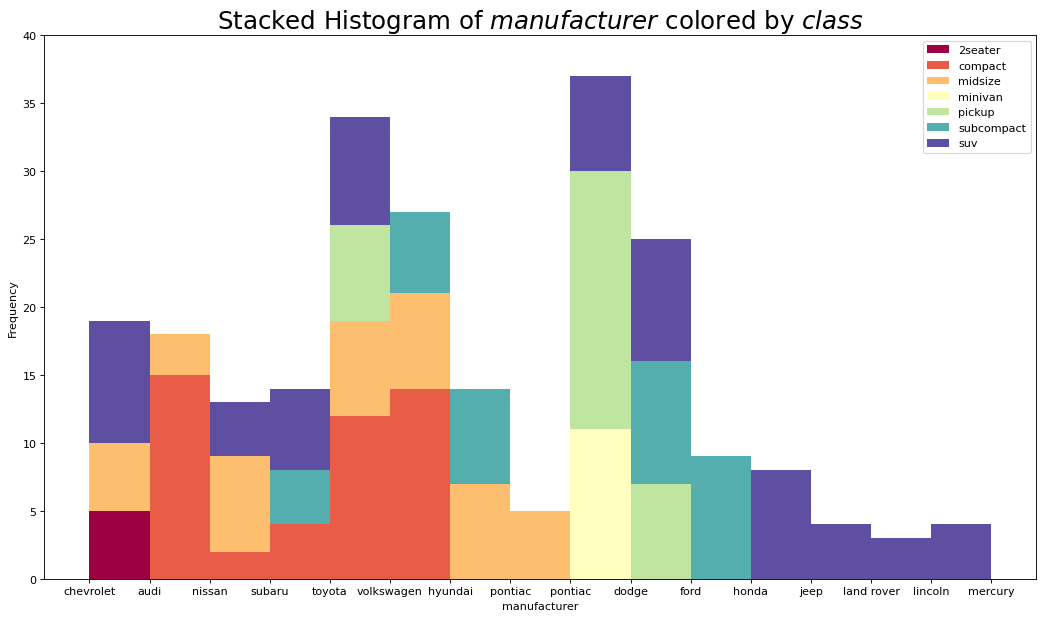

In [10]:
# Import Data
df = pd.read_csv("https://github.com/selva86/datasets/raw/master/mpg_ggplot2.csv")

# Prepare data
x_var = 'manufacturer'
groupby_var = 'class'
df_agg = df.loc[:, [x_var, groupby_var]].groupby(groupby_var)
vals = [df[x_var].values.tolist() for i, df in df_agg]

# Draw
plt.figure(figsize=(16,9), dpi= 80)
colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
n, bins, patches = plt.hist(vals, df[x_var].unique().__len__(), stacked=True, density=False, color=colors[:len(vals)])

# Decoration
plt.legend({group:col for group, col in zip(np.unique(df[groupby_var]).tolist(), colors[:len(vals)])})
plt.title(f"Stacked Histogram of ${x_var}$ colored by ${groupby_var}$", fontsize=22)
plt.xlabel(x_var)
plt.ylabel("Frequency")
plt.ylim(0, 40)
plt.xticks(ticks=bins, labels=np.unique(df[x_var]).tolist(), rotation=90, horizontalalignment='left')
plt.show()